In [41]:
import plotly.offline as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from prophet import Prophet
from fancyimpute import IterativeImputer
import seaborn as sns

In [9]:
data = pd.read_csv('final_data.csv', low_memory = False)
data.drop(data.columns[0], axis=1)

,Unnamed: 0,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),...,soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),date,is_holiday,2_wheeler_motor,4_wheeler_motor,bikes_scooters
0,0,2020-01-01 00,42.900000,0.718000,15.7,73.1,64.4,-0.2,99,-0.3,...,12.0,0.380,0.385,0.383,0.288,2020-01-01 00:00:00,True,NaN,NaN,NaN
1,1,2020-01-01 01,33.600000,0.587000,10.1,74.8,66.0,2.6,98,2.3,...,12.0,0.382,0.386,0.383,0.288,2020-01-01 01:00:00,True,NaN,NaN,NaN
2,2,2020-01-01 02,29.300000,0.446091,5.1,51.0,44.9,2.1,100,2.0,...,12.0,0.382,0.386,0.383,0.288,2020-01-01 02:00:00,True,NaN,NaN,NaN
3,3,2020-01-01 03,30.500000,0.246000,7.2,27.7,25.1,1.9,100,1.9,...,12.0,0.382,0.386,0.383,0.288,2020-01-01 03:00:00,True,NaN,NaN,NaN
4,4,2020-01-01 04,29.300000,0.204000,8.3,15.3,13.6,2.2,98,1.9,...,12.0,0.382,0.386,0.383,0.288,2020-01-01 04:00:00,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,40986,2024-09-03 18,22.476504,0.222000,55.1,12.0,5.3,21.1,57,12.3,...,17.3,0.246,0.204,0.173,0.316,2024-09-03 18:00:00,False,117.0,36.0,1119.0
40987,40987,2024-09-03 19,25.452015,0.245000,48.2,13.4,7.0,19.7,64,12.7,...,17.3,0.245,0.204,0.173,0.316,2024-09-03 19:00:00,False,152.0,60.0,484.0
40988,40988,2024-09-03 20,24.303319,0.234000,44.5,12.4,7.1,18.7,67,12.6,...,17.3,0.245,0.204,0.173,0.316,2024-09-03 20:00:00,False,111.0,32.0,760.0
40989,40989,2024-09-03 21,28.484285,0.225000,25.9,10.6,5.4,16.9,76,12.7,...,17.3,0.245,0.204,0.173,0.316,2024-09-03 21:00:00,False,87.0,3.0,647.0


In [34]:
data['id'] = pd.DatetimeIndex(data['id'])
data['day_of_week'] = data['id'].dt.day_name()
data.drop(['date'], axis = 1, inplace = True)
data.drop(data.columns[0], axis = 1, inplace = True)


# Modelling

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40991 entries, 0 to 40990
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  40991 non-null  datetime64[ns]
 1   valeur_NO2                          40991 non-null  float64       
 2   valeur_CO                           40991 non-null  float64       
 3   valeur_O3                           40991 non-null  float64       
 4   valeur_PM10                         40991 non-null  float64       
 5   valeur_PM25                         40991 non-null  float64       
 6   temperature_2m (°C)                 40991 non-null  float64       
 7   relative_humidity_2m (%)            40991 non-null  int64         
 8   dew_point_2m (°C)                   40991 non-null  float64       
 9   apparent_temperature (°C)           40991 non-null  float64       
 10  precipitation (mm)    

In [47]:
import pandas as pd

# Assuming df is your DataFrame containing all the data

# Selecting the target columns and potential regressor columns
target_columns = [
    'valeur_NO2', 
    'valeur_CO', 
    'valeur_O3', 
    'valeur_PM10', 
    'valeur_PM25'
]

# Include all the columns you want to check for correlation, except the ID and other non-numeric columns
potential_regressors = [
    'temperature_2m (°C)', 
    'relative_humidity_2m (%)', 
    'dew_point_2m (°C)', 
    'apparent_temperature (°C)', 
    'precipitation (mm)', 
    'rain (mm)', 
    'snowfall (cm)', 
    'snow_depth (m)', 
    'surface_pressure (hPa)', 
    'cloud_cover (%)', 
    'wind_speed_10m (km/h)', 
    'wind_speed_100m (km/h)', 
    'wind_direction_10m (°)', 
    'wind_direction_100m (°)', 
    'wind_gusts_10m (km/h)', 
    'soil_temperature_0_to_7cm (°C)', 
    'soil_temperature_7_to_28cm (°C)', 
    'soil_temperature_28_to_100cm (°C)', 
    'soil_temperature_100_to_255cm (°C)', 
    'soil_moisture_0_to_7cm (m³/m³)', 
    'soil_moisture_7_to_28cm (m³/m³)', 
    'soil_moisture_28_to_100cm (m³/m³)', 
    'soil_moisture_100_to_255cm (m³/m³)', 
    '2_wheeler_motor', 
    '4_wheeler_motor', 
    'bikes_scooters'
]

# Concatenate target columns with regressor columns
correlation_df = data[target_columns + potential_regressors].corr()

# Select only the correlations of target columns with regressors
target_corr = correlation_df.loc[target_columns, potential_regressors]

# Filter correlations above 0.5 or below -0.5
significant_corr = target_corr[(target_corr > 0.5) | (target_corr < -0.5)]

# Create a DataFrame to hold the correlation pairs
correlation_pairs = []

for target in target_columns:
    for regressor in potential_regressors:
        corr_value = significant_corr.loc[target, regressor]
        if not pd.isnull(corr_value):  # Only include non-null values
            correlation_pairs.append({'Target': target, 'Regressor': regressor, 'Correlation': corr_value})

# Convert to a DataFrame for better display
correlation_pairs_df = pd.DataFrame(correlation_pairs)

# Print the significant correlation pairs
print("Correlation Pairs with |Correlation| > 0.5:")
print(correlation_pairs_df)

Correlation Pairs with |Correlation| > 0.5:
      Target                       Regressor  Correlation
0  valeur_O3             temperature_2m (°C)     0.578206
1  valeur_O3        relative_humidity_2m (%)    -0.697546
2  valeur_O3       apparent_temperature (°C)     0.511857
3  valeur_O3  soil_temperature_0_to_7cm (°C)     0.563783


## NO2

In [48]:
data_NO2 = data[['id', 'valeur_NO2', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)', 'soil_temperature_0_to_7cm (°C)']].rename(columns={'id' : 'ds', 'valeur_NO2' : 'y'})
data_NO2

,ds,y,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),soil_temperature_0_to_7cm (°C)
0,2020-01-01 00:00:00,42.900000,-0.2,99,-2.7,1.1
1,2020-01-01 01:00:00,33.600000,2.6,98,0.3,1.8
2,2020-01-01 02:00:00,29.300000,2.1,100,-0.3,2.2
3,2020-01-01 03:00:00,30.500000,1.9,100,-0.7,2.4
4,2020-01-01 04:00:00,29.300000,2.2,98,-0.7,2.6
...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,22.476504,21.1,57,21.1,21.7
40987,2024-09-03 19:00:00,25.452015,19.7,64,19.8,21.1
40988,2024-09-03 20:00:00,24.303319,18.7,67,18.4,20.4
40989,2024-09-03 21:00:00,28.484285,16.9,76,16.7,19.6


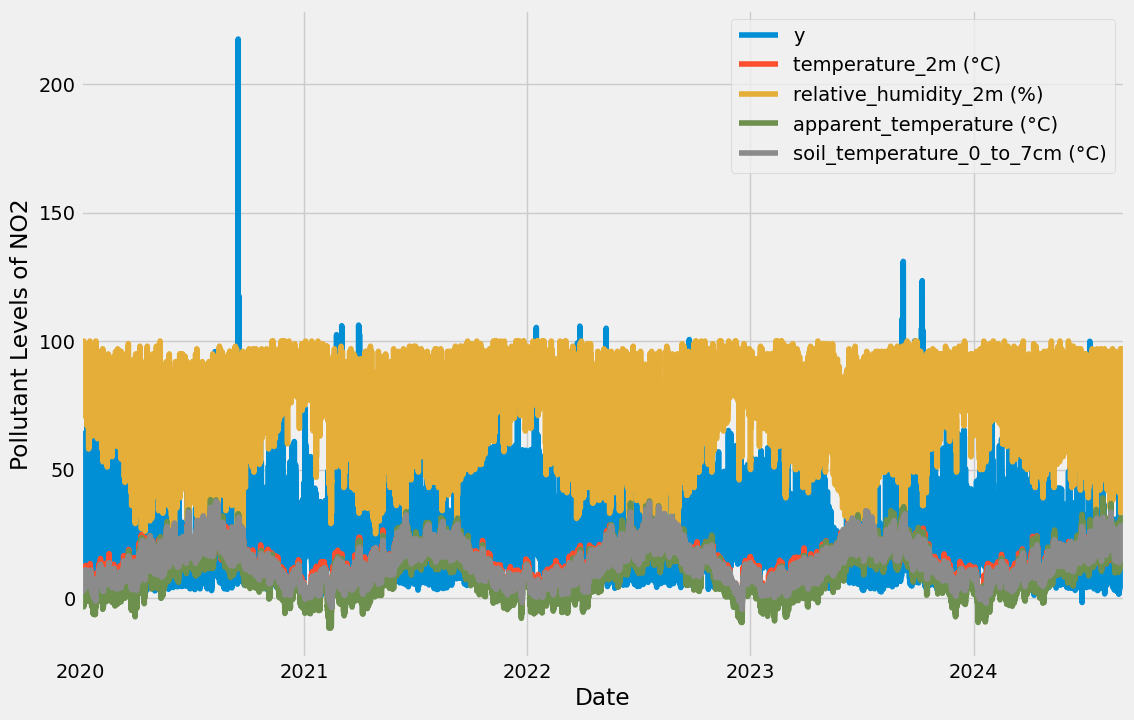

In [49]:
NO2 = data_NO2.set_index('ds').plot(figsize = (12, 8))
NO2.set_ylabel('Pollutant Levels of NO2')
NO2.set_xlabel('Date')

plt.show()

In [50]:
#define loss function 
def mae(y_true, y_pred):
    
    # Convert inputs to numpy arrays for easier calculations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the MAE
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [51]:
data_NO2_train, data_NO2_test= np.split(data_NO2, [int(.67 *len(data_NO2))])

model1 = Prophet()
model1.add_regressor('temperature_2m (°C)')
model1.add_regressor('relative_humidity_2m (%)')
model1.add_regressor('apparent_temperature (°C)')
model1.add_regressor('soil_temperature_0_to_7cm (°C)')
model1.fit(data_NO2_train)

17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
test_forecast_NO2 = model1.predict(data_NO2_test)
test_forecast_NO2 = test_forecast_NO2.rename(columns = {'ds' : 'id', 'yhat' : 'valeur_NO2'})
test_forecast_NO2_new = test_forecast_NO2[['id', 'valeur_NO2']].copy()

In [53]:
test_forecast_NO2_new

,id,valeur_NO2
0,2023-02-18 07:00:00,36.486047
1,2023-02-18 08:00:00,34.409868
2,2023-02-18 09:00:00,28.952871
3,2023-02-18 10:00:00,26.919954
4,2023-02-18 11:00:00,20.741034
...,...,...
13523,2024-09-03 18:00:00,49.080115
13524,2024-09-03 19:00:00,49.787192
13525,2024-09-03 20:00:00,47.075170
13526,2024-09-03 21:00:00,45.910285


In [54]:
NO2_mae = mae(data_NO2_test['y'], test_forecast_NO2_new['valeur_NO2'])
NO2_mae

17.34128068065673

In [ ]:
forecast_NO2 = model.predict(test)
forecast_NO2 = forecast_NO2.rename(columns = {'ds' : 'id', 'yhat' : 'valeur_NO2'})
predictions_NO2 = forecast_NO2[['id', 'valeur_NO2']].copy()
predictions_NO2